In [1]:
import statsmodels as sm
from statsmodels import api as smi
from statsmodels import graphics as smg
from statsmodels import tsa as tsa 

import numpy as np
from scipy import stats as SPstats
from time import strptime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
# import pygal as pg
import itertools as it
import math
import datetime
%matplotlib inline



sm.__version__

/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


'0.8.0'

## Data Preparation and Plotting

In [2]:
rentalDat_initial = pd.read_csv('CitiBike_RentalDetails2018-03-20.csv')
rentalDat_initial.columns = ['Date', 'RentalCount']
# 0 == Monday, 6 == Sunday
rentalDat_initial['DoW'] = pd.to_datetime(rentalDat_initial['Date']).apply(datetime.date.weekday)
rentalDat_initial['MoY'] = pd.to_datetime(rentalDat_initial['Date']).apply(lambda x: x.month)
rentalDat_initial['LogRental'] = rentalDat_initial['RentalCount'].apply(math.log)
rentalDat_initial['Lag1 LogRental'] = rentalDat_initial['LogRental'].shift()
rentalDat_initial['Diff1 LogRental'] = rentalDat_initial['LogRental'] - rentalDat_initial['Lag1 LogRental']
rentalDat_initial['Date'] = pd.to_datetime(rentalDat_initial['Date'])
rentalDat_initial.sort_values('Date', inplace=True, ascending=False)


# set cutoff for startdate below
startDate = pd.to_datetime('2014-01-01')

rentalDat = rentalDat_initial[pd.to_datetime(rentalDat_initial['Date']) >= startDate]
rentalDat.set_index('Date', drop=False, inplace=True)

rentalDat.dropna(inplace=True)
rentalDat.shape

/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1528, 7)

In [3]:
rentalDat.columns

Index(['Date', 'RentalCount', 'DoW', 'MoY', 'LogRental', 'Lag1 LogRental',
       'Diff1 LogRental'],
      dtype='object')

#### De-Seasonalize

In [4]:
DOWavg = pd.DataFrame(rentalDat.groupby('DoW')['LogRental'].mean())
DOWavg.columns = ['DoW avg']
MOYavg = pd.DataFrame(rentalDat.groupby('MoY')['LogRental'].mean())
MOYavg.columns = ['MoY avg']


In [5]:
# run once! 
rentalDat = rentalDat.merge(DOWavg, how='left', left_on='DoW', right_index=True)
rentalDat = rentalDat.merge(MOYavg, how='left', left_on='MoY', right_index=True)

In [6]:
rentalDat['LogRental+'] = rentalDat['LogRental'].map(lambda x: x + 20)
rentalDat['LogRental_desea'] = rentalDat['LogRental+'] - rentalDat['MoY avg'] - rentalDat['DoW avg']
#rentalDat['LogRental_desea'] = rentalDat['LogRental_desea'].map(lambda x: x*100)
rentalDat['RentalCount'] = rentalDat['RentalCount'].apply(int)

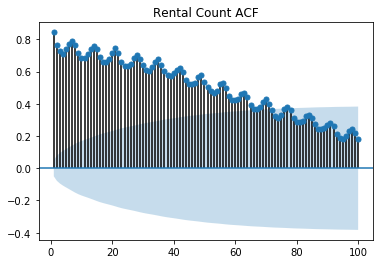

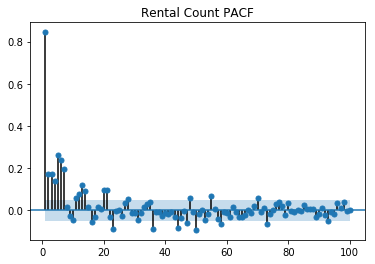

In [7]:
# LogRental ACF, PACF
smg.tsaplots.plot_acf(rentalDat['RentalCount'],lags=100, zero=False)
plt.title('Rental Count ACF')
smg.tsaplots.plot_pacf(rentalDat['RentalCount'], lags=100, zero=False)
plt.title('Rental Count PACF')

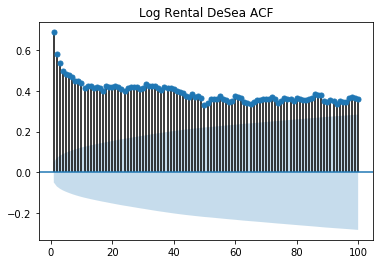

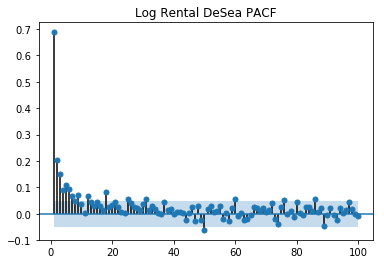

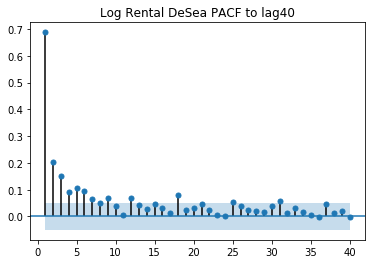

In [7]:
# LogRental Deseasonalized ACF, PACF
smg.tsaplots.plot_acf(rentalDat['LogRental_desea'],lags=100, zero=False)
plt.title('Log Rental DeSea ACF')
smg.tsaplots.plot_pacf(rentalDat['LogRental_desea'],lags=100,  zero=False)
plt.title('Log Rental DeSea PACF')

smg.tsaplots.plot_pacf(rentalDat['LogRental_desea'],lags=40,  zero=False)
plt.title('Log Rental DeSea PACF to lag40')

In [ ]:
# Diff1 LogRental ACF, PACF
smg.tsaplots.plot_acf(rentalDat['Diff1 LogRental'],lags=100, zero=False)
plt.title('Diff1 LogRental ACF')
smg.tsaplots.plot_pacf(rentalDat['Diff1 LogRental'], lags=100, zero=False)
plt.title('Diff1 LogRental PACF')

In [ ]:
# plot rentals and log rentals
fig, rental_plot = plt.subplots(nrows=3,ncols=1, figsize=(14,10))
fig.subplots_adjust(hspace = .5)
rental_plot[0].plot(pd.to_datetime(rentalDat.index), rentalDat['RentalCount'])
rental_plot[0].set_title('Rentals')
rental_plot[1].plot(pd.to_datetime(rentalDat.index), rentalDat['LogRental'])
rental_plot[1].set_title('Log Rentals')
rental_plot[2].plot(pd.to_datetime(rentalDat.index), rentalDat['LogRental_desea'])
rental_plot[2].set_title('Log Rentals Deseasonalized')

## Model Selection

In [8]:
# use function below to calculate AICc for different combinations 

def calcAICc(observations, constant):
    
    trendVal = str(constant)
    # below is for all combinations of (p,q) <= 2
    combos = list(it.product(range(8),repeat=2))
    result_li = []
    
    
    for ea in combos: 
        ARMAaiccCalc = tsa.arima_model.ARMA(observations,order=ea) 
        # trend= indicates whether to use constant('c') or not ('nc'). 
        try:
            ARMAaiccCalc = ARMAaiccCalc.fit(trend=trendVal)
            logLikeli = ARMAaiccCalc.llf
            n_obs = ARMAaiccCalc.nobs
            #AICc calc
            AICc =  -2*logLikeli + 2*(sum(ea) + 1)*(n_obs/(n_obs-sum(ea)-2))
        except (ValueError, Exception): 
            AICc = 0
            pass

    
        result_li.append([ea, AICc])
        
    res_DF = pd.DataFrame(result_li)
    res_DF.columns = ['(p,q)','AICc']
    # res_DF['Abs AICc'] = abs(res_DF['AICc'])
    res_DF.sort_values('AICc', ascending=True, inplace=True)
    
    return res_DF
        
    



In [ ]:
# run AICc both with and without constant added
aicsNC = calcAICc(rentalDat['LogRental_desea'],'nc')
aicsC = calcAICc(rentalDat['LogRental_desea'],'c')

In [ ]:
aicsNC.to_csv('aicc-NC.csv')

In [ ]:
aicsC.to_csv('aicc-C.csv')

## Model Fitting

In [9]:
# fit an ARMA(3,2) model.
rentalDeSea_ARMA32 = tsa.arima_model.ARMA(rentalDat['LogRental_desea'],order=(3,2))
# trend='nc' removes constant 
rentalDeSea_ARMA32 = rentalDeSea_ARMA32.fit(trend='c')
rentalDeSea_ARMA32.summary()

/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:        LogRental_desea   No. Observations:                 1528
Model:                     ARMA(3, 2)   Log Likelihood                -588.605
Method:                       css-mle   S.D. of innovations              0.355
Date:                Tue, 01 May 2018   AIC                           1191.210
Time:                        15:12:51   BIC                           1228.532
Sample:                    03-19-2018   HQIC                          1205.101
                         - 01-01-2014                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.7541      0.404     24.145      0.000       8.962      10.546
ar.L1.LogRental_desea     2.0170      0.002   1303.620      0.000       2.014       2.020
ar.L2.LogRental_desea    -1.2128      0.003   -471.315      0.000      -1.218      -1.208
ar.L3.LogRental_desea     0.1957      0.002     94.911      0.000       0.192       0.200
ma.L1.LogRental_desea    -1.5894      0.021    -77.152      0.000      -1.630      -1.549
ma.L2.LogRental_desea     0.5986      0.021     29.120      0.000       0.558       0.639
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
AR.2            1.3160           +0.0000j            1.3160            0.0000
AR.3            3.8792           +0.0000j            3.8792            0.0000
MA.1            1.0243           +0.0000j            1.0243            0.0000
MA.2            1.6309           +0.0000j            1.6309            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
rentalDat.to_csv('CB_rentalDatfull.csv')

In [10]:
rentalDeSea_ARMA32.plot_diagnostics()

AttributeError: 'ARMAResults' object has no attribute 'plot_diagnostics'

## ARMA(3,2) Analysis of Residuals 

/Users/Sam_I_Am/anaconda/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


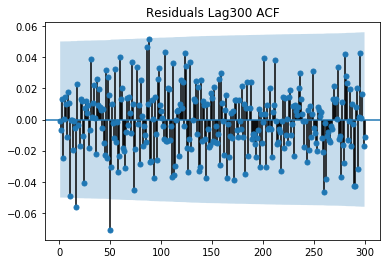

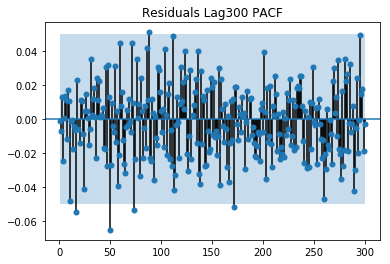

In [11]:
ARMA32_resids = rentalDeSea_ARMA32.resid

# ARMA(3,2) residuals ACF, PACF
smg.tsaplots.plot_acf(ARMA32_resids,lags=300, zero=False)
plt.title('Residuals Lag300 ACF')
smg.tsaplots.plot_pacf(ARMA32_resids,lags=300,  zero=False)
plt.title('Residuals Lag300 PACF')

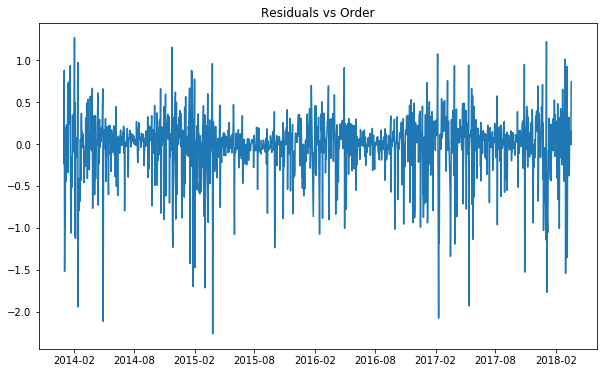

In [12]:
plt.figure(figsize=(10,6))
plt.title("Residuals vs Order")
plt.plot(pd.to_datetime(ARMA32_resids.index), ARMA32_resids)


In [13]:
ljb_lags = list(range(12,72,12))
ARMA32_ljb = sm.stats.diagnostic.acorr_ljungbox(ARMA32_resids, lags=ljb_lags)

In [14]:
ARMA32_ljb

(array([ 6.29539178, 16.3710171 , 21.48038577, 28.39544213, 45.88835116]),
 array([0.90046533, 0.87422104, 0.97354985, 0.98911669, 0.91046674]))

In [15]:
ljbDf = pd.DataFrame(ARMA32_ljb[1])
ljbDf['Lag'] = ljb_lags
ljbDf.columns = ['Lj-B Pvalue','Lag']
ljbDf

,Lj-B Pvalue,Lag
0,0.900465,12
1,0.874221,24
2,0.973550,36
3,0.989117,48
4,0.910467,60


## Plot Forecast

In [16]:
ARMA32_forecast = rentalDeSea_ARMA32.forecast(steps=50)
ARMA32_forecast
fcast_start = pd.to_datetime(rentalDat.index).max()
fcast_end = fcast_start + pd.Timedelta(value=49, unit='D')
fcast_time = pd.date_range(start=fcast_start, end=fcast_end)
ARMA32_forecast


(array([8.97535562, 9.04475525, 9.08940993, 9.121324  , 9.14511969,
        9.16314931, 9.17690135, 9.18742973, 9.19551543, 9.20174676,
        9.20656943, 9.21032178, 9.2132608 , 9.21558177, 9.21743303,
        9.21892734, 9.22015034, 9.22116713, 9.22202717, 9.22276804,
        9.2234183 , 9.22399965, 9.22452858, 9.22501762, 9.22547628,
        9.2259118 , 9.22632968, 9.22673409, 9.22712821, 9.22751445,
        9.22789465, 9.22827019, 9.22864213, 9.22901128, 9.22937825,
        9.2297435 , 9.23010739, 9.23047019, 9.23083209, 9.23119325,
        9.2315538 , 9.23191381, 9.23227337, 9.23263251, 9.23299129,
        9.23334972, 9.23370783, 9.23406565, 9.23442318, 9.23478043]),
 array([0.35538275, 0.38650008, 0.39643017, 0.40142553, 0.40454422,
        0.40669939, 0.40827973, 0.40949201, 0.41045945, 0.41125981,
        0.41194382, 0.41254542, 0.41308774, 0.4135869 , 0.41405424,
        0.41449791, 0.41492379, 0.4153362 , 0.4157383 , 0.41613247,
        0.41652045, 0.41690356, 0.41728279, 0.

In [17]:
pd.to_datetime(rentalDat.index).max()

Timestamp('2018-03-19 00:00:00')

In [18]:
#rentalDat['Date'] = pd.to_datetime(rentalDat['Date'])
#rentalDat.sort_values('Date', inplace=True, ascending=False)
#rental_resort = rentalDat.set_index('Date', drop=False)
rentalDat

,Date,RentalCount,DoW,MoY,LogRental,Lag1 LogRental,Diff1 LogRental,DoW avg,MoY avg,LogRental+,LogRental_desea
Date,,,,,,,,,,,
2018-03-19,2018-03-19,38712,0,3,10.563905,10.462046,0.101859,10.270388,9.795072,30.563905,10.498445
2018-03-18,2018-03-18,25538,6,3,10.147923,10.563905,-0.415982,10.023184,9.795072,30.147923,10.329668
2018-03-17,2018-03-17,28108,5,3,10.243810,10.147923,0.095887,10.019276,9.795072,30.243810,10.429462
2018-03-16,2018-03-16,35572,4,3,10.479314,10.243810,0.235505,10.265931,9.795072,30.479314,10.418312
2018-03-15,2018-03-15,40267,3,3,10.603288,10.479314,0.123973,10.331468,9.795072,30.603288,10.476748
2018-03-14,2018-03-14,36121,2,3,10.494630,10.603288,-0.108658,10.355231,9.795072,30.494630,10.344327
2018-03-13,2018-03-13,23638,1,3,10.070611,10.494630,-0.424019,10.324732,9.795072,30.070611,9.950808
2018-03-12,2018-03-12,37067,0,3,10.520482,10.070611,0.449871,10.270388,9.795072,30.520482,10.455023
2018-03-11,2018-03-11,27981,6,3,10.239281,10.520482,-0.281201,10.023184,9.795072,30.239281,10.421026


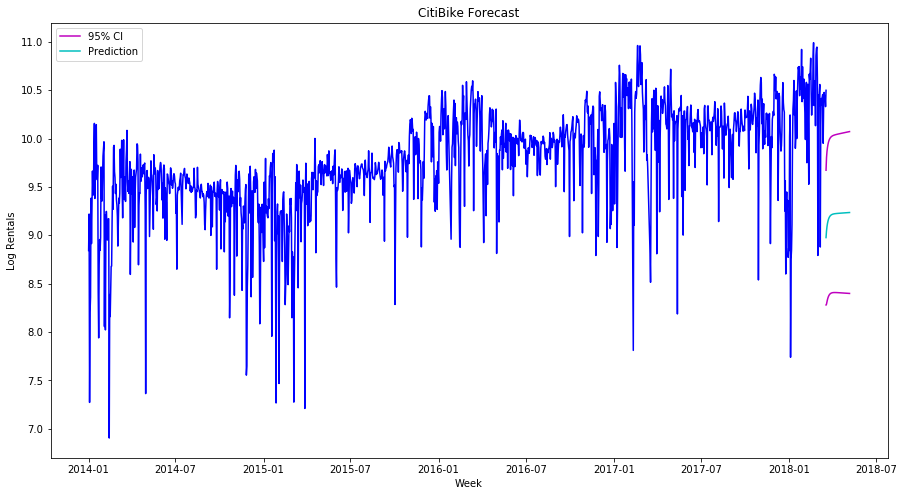

In [19]:
# single plot with 2 scales
legend_line = mlines.Line2D([],[],color='m',markersize=15, label='95% CI') 
legLine2 = mlines.Line2D([],[],color='c',markersize=15, label='Prediction')

fig, fcast_plot =  plt.subplots(figsize=(15,8))
fcast_plot.plot(pd.to_datetime(rentalDat['Date']), rentalDat['LogRental_desea'], 'b-')
fcast_plot.plot(fcast_time,ARMA32_forecast[0], 'c-')
fcast_plot.plot(fcast_time,ARMA32_forecast[2][:,0], 'm-')
fcast_plot.plot(fcast_time,ARMA32_forecast[2][:,1], 'm-')
fcast_plot.set_xlabel('Week')
fcast_plot.set_ylabel('Log Rentals', color='k')


fcast_plot.legend(handles=[legend_line, legLine2])
fcast_plot.set_title("CitiBike Forecast")

In [ ]:
x_val = list(range(len(rentalDat['LogRental_desea'])))

In [ ]:
trend_test = sm.regression.linear_model.OLS(rentalDat['LogRental_desea'], x_val, hasconst=True)
trend_test = trend_test.fit()
trend_test.summary()

In [ ]:
trend_test.resid.hist()